Optimizando max_depth para: Scale Pos Weight...
Optimizando max_depth para: SMOTE + Tomek...
Optimizando max_depth para: SMOTE + ENN...
Optimizando max_depth para: NearMiss...
Optimizando max_depth para: ADASYN...


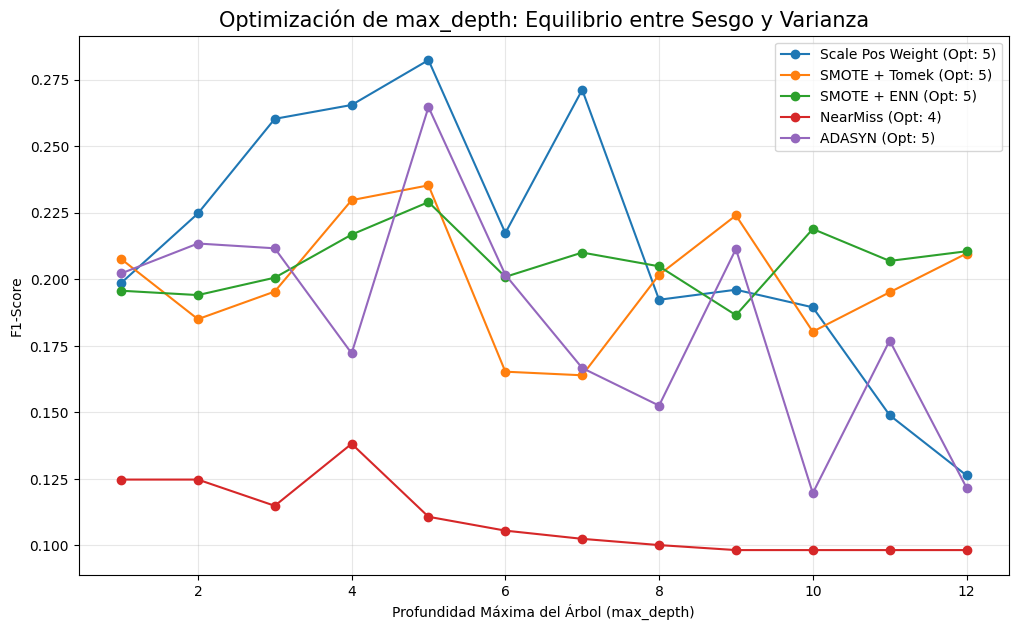


TÉCNICA              | BEST DEPTH | MAX F1  
------------------------------------------------------------
Scale Pos Weight     | 5          | 0.2824
SMOTE + Tomek        | 5          | 0.2353
SMOTE + ENN          | 5          | 0.2290
NearMiss             | 4          | 0.1382
ADASYN               | 5          | 0.2647


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación de datos (Codificación completa)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)

X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ratio_balanceo = float(np.sum(y_train == 0) / np.sum(y_train == 1))

# 2. Configuración con los mejores valores encontrados (Fase 1 y 2)
# {Nombre: (Sampler, n_estimators, learning_rate)}
config_final = {
    'Scale Pos Weight': (None, 125, 0.1),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1),
    'NearMiss': (NearMiss(), 271, 0.001),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15)
}

depth_range = range(1, 13) # Probamos de 1 a 12 niveles de profundidad
final_depth_results = []

plt.figure(figsize=(12, 7))

for nombre, (sampler, n_opt, lr_opt) in config_final.items():
    depth_f1 = []
    
    if nombre == 'Scale Pos Weight':
        X_res, y_res = X_train, y_train
        spw = ratio_balanceo
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        spw = 1
        
    print(f"Optimizando max_depth para: {nombre}...")
    
    for d in depth_range:
        model = XGBClassifier(
            n_estimators=n_opt,
            learning_rate=lr_opt,
            max_depth=d,
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        depth_f1.append(f1_score(y_test, y_pred))
    
    # Identificar el mejor valor
    max_f1 = max(depth_f1)
    best_d = depth_range[depth_f1.index(max_f1)]
    final_depth_results.append({
        'Técnica': nombre,
        'Best Depth': best_d,
        'Max F1': max_f1
    })
    
    plt.plot(depth_range, depth_f1, marker='o', label=f"{nombre} (Opt: {best_d})")

plt.title('Optimización de max_depth: Equilibrio entre Sesgo y Varianza', fontsize=15)
plt.xlabel('Profundidad Máxima del Árbol (max_depth)')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Reporte de Resultados Finales
print("\n" + "="*60)
print(f"{'TÉCNICA':<20} | {'BEST DEPTH':<10} | {'MAX F1':<8}")
print("-"*60)
for r in final_depth_results:
    print(f"{r['Técnica']:<20} | {r['Best Depth']:<10} | {r['Max F1']:.4f}")
print("="*60)